# An Introduction to the Immersed Boundary Method

We introduce a simple, object-oriented python implementation of the 2D immersed boundary method, and demonstrate by modeling an elastic fiber immersed in an incompressible fluid. This closely follows the formalism outlined in Charles Peskin's Immersed Boundary Method course, and much of the underlying code is adapted from the IB-MATLAB implementation by Guanha Sun on Github.

## A Broad Overview

Very broadly, hydrodynamics are governed by the Navier Stokes, which for an incompressible fluid are

$ \rho(\partial_t + \vec{u}\cdot\vec{\nabla})\vec{u} = \mu\nabla^2 \vec{u} - \vec{\nabla} P + \rho\vec{f}$

$\vec{\nabla}\cdot\vec{u}=0$

with density $\rho$ and velocity $u$, viscosity $\mu$, pressure $P$, and where $f$ is an external force density. These equations can easily be solved if boundary conditions are simple. However, NS are hard to solve for complex boundary conditions, so modeling the flow around a strangely shaped obstacle - especially a deformable obstacle - is difficult. 

The Immersed Boundary method accounts for these fluid-structure interactions by approximating the *force* exerted locally by an immersed body onto the surrounding fluid, and vice versa. Consequently, we can model the fluid by solving Navier Stokes on a grid with periodic boundary conditions and an external force, which is much easier and faster than treating the boundary directly.


## Implementation
We start by defining the fluid $u$ on a Cartesion (Eulerian) grid, and treat the boundary as a set of Lagrangian points $X$ which move at the local fluid velocity $U$ (i.e. no-slip) and are connected by springs of stiffness $K$. Crucially, we use a *discrete dirac delta function* to transform between Eulerian and Lagrangian coordinates. Our algorithm is the following:

- First, we *interpolate* the local fluid velocity $\vec{u}$ to find the boundary velocity $\vec{U}\big(\vec{X}(r,s)\big) = \int\vec{u}\big(\vec{x}\big)\delta \big(\vec{x} - \vec{X}(r,s)\big)d\vec{x}$ 
- Next, we update the boundary position $\vec{X}(t+\Delta t) = \vec{X}(t) + \vec{U}(\vec{X})\Delta t$, and compute the elastic spring force $\vec{F}(\vec{X})$ at each boundary point
- We then *spread* the Lagrangian force locally onto the fluid  $\vec{f}\big(\vec{x}) = \int\vec{F}(r,s)\delta \big(\vec{x} - \vec{X}(r,s)\big)drds$ 
- Finally, we solve Navier Stokes with the external force density $\vec{f}$ to update the fluid $\vec{u}$.

Here, we use the four-point dirac-delta function constructed by Peskin - which effectively means we interpolate to / spread from the nearest 4x4(x4) Eulerian points, with the appropriate weights. The algorithm we use differs slightly - we essentially use a "midpoint" method and compute boundary forces at an intermediate "half-step" boundary to improve symmetry - but the general idea remains the same.

## Class Structure

The Immersed Boundary Method is designed to decouple dynamics of the fluid from those of the immersed body, in order to study the underlying fluid-structure interaction. Consequently, an intuitive class structure for this code would be to designate a class for the fluid, and a class for the immersed body; 

### fluid.py
The object FLUID represents the fluid, consisting of
- fluid fields ($u$), and relevant fluid parameters ($\eta$, $\rho$)
- system parameters $N$, $h$ and $dt$
- method *solve($ff$)* to solve the Navier Stokes equations for force density $ff$
- method *step_u($ff$)* to increment the velocity $u$ (using *solve*)


### ib2.py
The object IB2.py represents an immersed solid, consisting of
- boundary position $X$, and relevant ib parameters ($K$, $d\theta$)
- system parameters $N$, $h$, and $dt$, defined in the corresponding fluid
- methods to *interpolate($u$, $X$)* and *spread($F$, $X$)* quantities to and from the corresponding fluid
- method *Force(X)* to compute Lagrangian force for boundary configuration $X$
- methods *step_XX($u$)*, *step_X($uu$)* to increment the boundary position $X$ (using *interp*)

This class structure emphasizes the flexibilities of the method itself. One advantage of the IBM is that any fluid solver may be used - 




<!-- ## Implementation

 The immersed boundary method generally proceeds as follows:

- At each timestep, we interpolate the local fluid velocity $u(t)$ to find the boundary velocity $U(t)$ and then estimate the new boundary position $X$


- The elastic force at the new boundary point $X_k$ is $F_k \approx K(X_{k+1}-X_k) + K(X_k-X_{k-1})$. At each boundary point, we spread this force to the fluid and then solve Navier Stokes with the resulting external force density $f$ to compute the new fluid velocity $u$


To properly model the time evolution of the system, we must calculate both the velocity of the fluid $u^{n+1}$ and the position of the immersed boundary $X^{n+1}$ at each timestep. Since the boundary motion is determined by the fluid velocity, and force exerted on the fluid is determined by the boundary position, calculating both of these simultaneously is tricky. Consequently, we *iterate* the system by first computing the boundary position at a *half* timestep $X^{n+1/2}$, and use the resulting 'midpoint' force $F^{n+1/2}$ to compute both the updated fluid velocity $u^{n+1}$, and the 'midpoint' fluid velocity $u^{n+1/2}$ used to compute the updated boundary position $X^{n+1}$. Explicitly,

- We first compute the *midpoint* boundary position  $XX = X(t+\frac{dt}{2} \approx X(t)+\frac{dt}{2}U(t)$, and then compute the force density $ff$ at the midpoint. 
- We then solve Navier Stokes subject to $ff$ to find both the updated fluid velocity $u(t+dt)$; and the midpoint fluid velocity $uu\equiv u(t+\frac{dt}{2})$
- Finally, we interpolate $uu$ to find the midpoint boundary velocity $UU \equiv U(t+\frac{dt}{2})$, and the updated boundary $X(t+dt) = X(t) + UUdt$
 -->
 
# The Fluid Solver: Poisseuille and Couette Benchmark

In this code, we use fast fourier transforms (FFT's) to solve NS on a periodic grid. This FFT algorithm requires periodic boundary conditions, but is also easy to implement and very efficient. Workarounds also exist to model non-periodic boundary conditions, as we shall now see.

To introduce the fluid class and benchmark the solver, we illustrate two flows. First, we simulate a Poisseuille flow, or a pressure-driven flow through a no-slip channel. We apply a constant force density $f$ at the inlet and outlet of the channel, and impose the no-slip condition $u=0$ at the top and bottom of the domain. Second, we model a Couette (shear) flow by imposing moving walls $u = \pm0.5 \hat{x}$ at the top and bottom respectively. To impose velocity boundary conditions, we use "ghost cells" at the walls, where we set the value of $u$ explicitly before and after using the FFT solver ( fluid.solve() ). 

In [1]:
#### Script for IBM simulation of a single droplet in incompressible, periodic fluid
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import gridspec

from IPython.display import display


from fluid2 import FLUID    #### Generic fluid solver
# from ib2 import IB2         #### 2D Immersed Boundary object for later
from ib2_amr import IB2_AMR as IB2

# from fluidmac2 import FLUIDMAC as FLUID    #### Generic fluid solver
# from ibmac2 import IBMAC2
# from ib2_amr import IB2_AMR
# class IB2(IBMAC2, IB2_AMR): pass


from util import *          #### General functions (iterate, geometry, force functions, etc)
import warnings; warnings.simplefilter('ignore')

%matplotlib notebook 

def channel(u):       ## No-slip channel
    u[0][:, 0] = 0.
    u[0][:,-1] = 0.

    u[1][:, 0] = 0.
    u[1][:,-1] = 0.
    
    
def couette(u):       ## Moving Walls
    u[0][:, 0] = .25
    u[0][:,-1] = -.25

    u[1][:, 0] = 0.
    u[1][:,-1] = 0.
    
    
    
# def channel(u):
#     u[0][:, 0] = -u[0][:, 1]
#     u[0][:,-1] = -u[0][:, -2]

#     u[1][:, 0] = -u[1][:, 1]
#     u[1][:,-1] = -u[1][:, -2]

In [2]:
%matplotlib notebook 


<IPython.core.display.Javascript object>


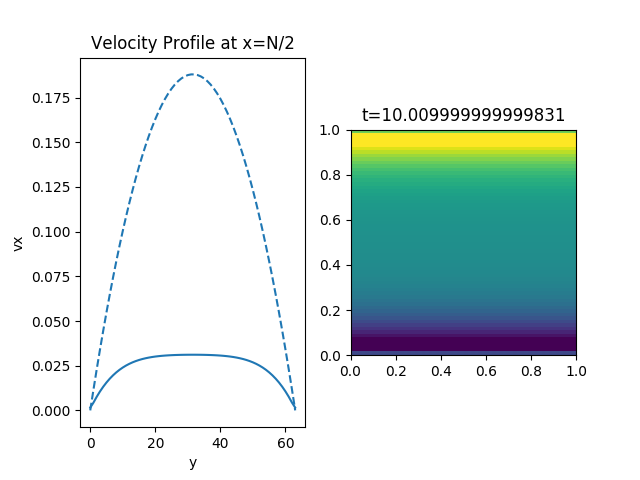

1000

In [2]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 1000            # simulation time 
nmod = 20               # save every nmod frames
    
fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
fluid.boundary = channel   
# fluid.u[0]=100.
inlet_pressure = 0*fluid.u
inlet_pressure[0][1, :] = 1.    ## External force density is pressure-driven flow at inlet
# inlet_pressure[0] = 100.    
fluid2 = FLUID(N=N, L=L, mu=mu, dt=dt)
fluid2.boundary = couette   

fig = plt.figure()

# Velocity Profile
ax = fig.add_subplot(1,2,1)
ax.set_title('Velocity Profile at x=N/2')
ax.set_xlabel('y')
ax.set_ylabel('vx')
# ax.axhline(y=0, linestyle='--', color='black')

cmap = plt.get_cmap('tab10')
y = np.linspace(0, fluid.L, fluid.N)
u_theo = -.752*y*(y-fluid.L)
profile_theo = ax.plot(u_theo, linestyle='--', color=cmap(0))

#### Vorticity Map
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim([0, fluid.L])
ax2.set_ylim([0, fluid.L])

ims = []
dh = display('', display_id=True)
for i in range(nsteps+1):
    uu = fluid.step_u(inlet_pressure)
    uu = fluid2.step_u(0.)
    if i%nmod==0:
        dh.update(i)
        #Velocity Profile
        im = ax.plot(fluid.u[0][int(fluid.N/2), :], color=cmap(0))  ## ax.plot returns a list of 2DLines (e.g. list of artists)
#         im.extend(ax.plot(fluid2.u[0][int(fluid2.N/2), :], color=cmap(1)))  ## ax.plot returns a list of 2DLines (e.g. list of artists)
        im.extend(profile_theo)

        # Vorticity Map
        im.append(show_vorticity(fluid.u, fluid.L, ax2))     #### show_vorticity returns output from plt.imshow(), which is an artist
        im.append(ax2.set_title('t={}'.format(1*fluid.t)))
        ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=100)
# ani.save(ani_path+'2D_pois_vanilla.gif', writer='pillow')
# u_pois = fluid.u

In [3]:
# print(fluid.u[0])
# plt.plot(fluid.u[0][32, :])
# print(np.sum(fluid.u))
# print(fluid.Lhat1)

<IPython.core.display.Javascript object>


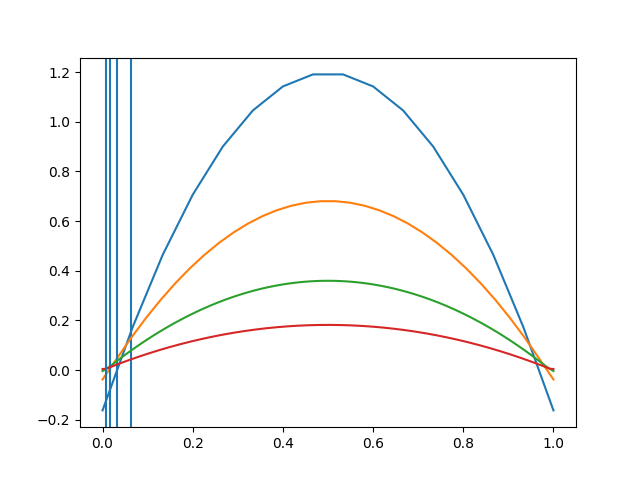

16
39.5400000000007
32
39.15000000000078
64
35.28000000000155
128
29.760000000001853


In [5]:
fig = plt.figure()
VELS = []
ZERO_VELS = []
TIMES = []
for N in [16, 32, 64, 128]:
    
    fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
    fluid.boundary = channel   
    inlet_pressure = 0*fluid.u
    inlet_pressure[0][0, :] = 1#(N-2)/16.#1.    ## External force density is pressure-driven flow at inlet
    inlet_pressure[0][-1, :] = 1#(N-2)/16.#1.    ## External force density is pressure-driven flow at inlet
    max_u=10
    while abs(np.max(fluid.u[0][int(fluid.N/2), :]) - max_u) > 1e-5 or fluid.t<0.8:
        max_u = np.max(fluid.u[0][int(fluid.N/2), :])
        uu = fluid.step_u(inlet_pressure)
    print(N)
    print(fluid.t)
    VELS.append(max_u)
    plt.plot(np.linspace(0,1,N), fluid.u[0][int(fluid.N/2), :])
    plt.axvline(x=1/N)
    ZERO_VELS.append(abs(fluid.u[0,int(fluid.N/2),0]) + abs(fluid.u[0,int(fluid.N/2),-1]))
#     ZERO_VELS.append((np.sum(abs(fluid.u[:,:,0])) + np.sum(abs(fluid.u[:,:,-1]))))
    TIMES.append(fluid.t)


In [17]:
print(VELS)
print(ZERO_VELS)

[1.3632220019713506, 0.7278423038185589, 0.37346874426660503, 0.18702401777222322]
[0.01990427794880289, 0.019802073272943088, 0.019596557283100585, 0.019181578590311124]


## Reynolds Number

In the specific case of flow through a pipe, the flow profile has the analytic form $v_x = \frac{Gy^2}{4\mu}$, where $y$ is the distance from the center of the pipe, and $G\equiv\Delta P/L$ is dependent on the pressure gradient.

Plugging in our boundary condition that the walls are moving at $u_0$ at a $y=L_y/2$, we have 

$u_0 = \frac{G(L/2)^2}{4\mu}$, and $v_x = u_0\big(\frac{2y}{L_y}\big)^2$

This allows us to quantify Reynolds number and the scale of the inlet flow $G$ in terms of system parameters.

# Immersed Bodies

Next, we add some elastic bodies. In particular, we add two circlular elastic membranes into the poisseuille-flow. This also illustrates the general workflow for these types of simulations:
Next, we illustrate a general procedure for modeling a system:

1) Initialize the fluid and fluid parameters (L, $\rho$, $\eta$, etc) and fields (i.e. $\vec{u}$)

2) Initialize the immersed boundary(ies) and specify relevant parameters (i.e. $K$)

3) Iterate the system in time


In [4]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 1500            # simulation time 
nmod = 20               # save every nmod frames

# Immersed Body Parameters
K = .010
Nb = 100
rad = [.2, .1]
positions = [[.1, .3], [.1, .8]]


def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

In [5]:
#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          ## Force density on fluid
    for solid in solids:
#         solid.XX=solid.X+(dt/2)*solid.interp(fluid.u,solid.X)  # Euler step to midpoint
#         F = solid.Force(solid.XX)
#         ff += solid.vec_spread(F,solid.XX) # Force at midpoint # Force at midpoint 
        solid.step_XX(fluid.u)                                   # equivalent built-in functions
        ff += solid.ff 
    ff += inlet_pressure
    uu=fluid.step_u(ff) # Step Fluid Velocity
    for solid in solids:
#         solid.X+=dt*solid.interp(uu,solid.XX) # full step using midpoint velocity         
        solid.step_X(uu)                        # built-in function            

####################################
  ########   Simulation   ########
####################################

fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
fluid.boundary = channel   
inlet_pressure = 0*fluid.u
inlet_pressure[0][0, :] = 1.    ## External force density is pressure-driven flow at inlet

solids = [IB2( CIRCLE(rad[i], positions[i], Nb), fluid.N, fluid.h, fluid.dt, K=K) for i in range(len(rad))]
for solid in solids: solid.n_tol = 0.01
#### Values that we're tracking
U = []
X = [[] for solid in solids]

dh = display('setting up poisseuille flow . . .', display_id=True)
for i in range(nsteps+1):
    if i<500: 
        iterate(fluid,[])
        continue
    iterate(fluid, solids)
    if i%nmod==0:
        dh.update(i)
        U.append(fluid.u.copy())
        for j, solid in enumerate(solids): X[j].append(solid.X.copy())
           

1500

1
1
1
1
1
1
1
1
1
1
1
1
14
1
20
1
21
1
22
1
24
9
24
14
26
14
26
15
27
15
28
16
29
16
30
16
30
17
30
17
31
17
32
17
32
18
33
18
33
18
34
19
34
18
34
19
35
19
35
19
35
20
36
19
36
20
36
20
36
20
37
21
37
20
37
21
37
20
38
21
37
21
38
21
38
21
38
22
39
21
38
22
39
21
38
22
39
22
39
22
39
22
39
22
39
22
40
22
39
22
40
22
39
23
40
22
40
22
40
23
40
22
40
23
40
22
41
23
40
22
41
23
40
22
41
23
41
23
41
22
41
23
41
23
41
22
41
23
41
23
42
23
41
22
42
23
41
23
42
23
42
22
41
23
42
23
42
23
42
22
42
23
42
23
43
23
42
22
42
23
43
23
42
22
43
23
43
23
42
22
43
23
43
23
43
22
43
23
43
23
43
22
43
23
44
23
43
22
43
23
44
23
43
22
44
23
44
23
43
23
44
22
44
23
44
23
44
22
44
23
44
23
44
23
44
22
45
23
44
23
44
22
45
23
44
23
45
23
44
22
45
23
45
23
45
23
44
23
45
22
45
23
45
23
45
23
45
23
45
23
45
23
46
23
45
23
45
22
46
23
45
23
46
23
45
23
46
23
45
23
46
23
46
23
46
23
46
23
45
23
46
23
46
23
46
23
46
24
46
23
46
23
46
23
47
23
46
24
46
23
47
23
46
24
46
23
47
23
46
24
47
23
46
24
47
23
47
24
46


<IPython.core.display.Javascript object>


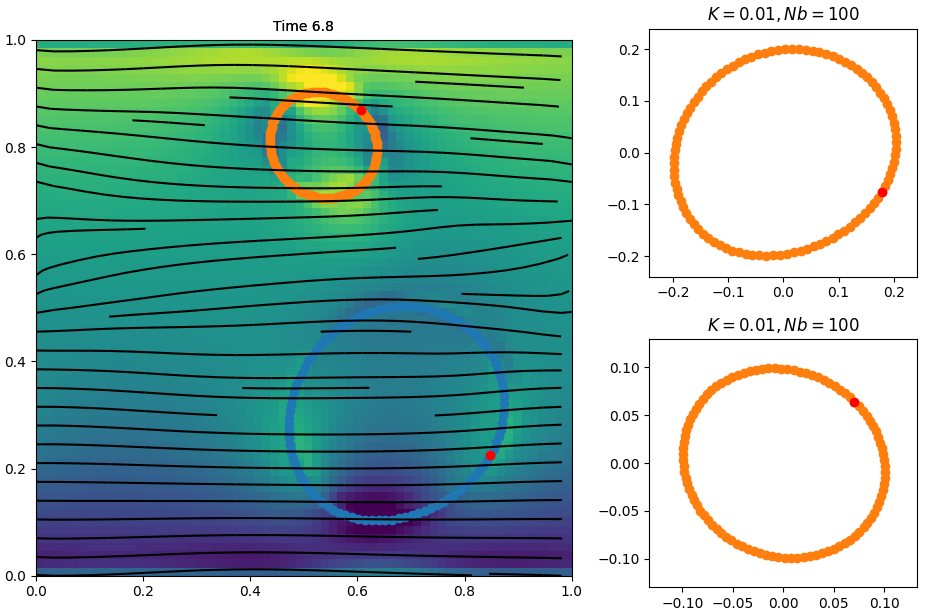

In [6]:
%matplotlib notebook 

#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for j, axj in enumerate(axes_frame):
        x = X[j][i]
        im.append(ax.scatter(x[:,0]%L, x[:,1]%L, color=cmap(j)))
        im.append(ax.scatter(x[0,0]%L, x[0,1]%L, color='Red'))
        im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))

        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1)))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [7]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

In [6]:
ani2.save('ST_pois_normal_Kpt01_noref.gif', writer='pillow')

# Couette Flow

In [7]:
# Fluid Parameters
L = 1.0                 # Domain Length
N = 64                 # Domain Points (NxN grid)
mu = 0.01               # viscosity
dt = 0.01             # timestep
nsteps = 2000            # simulation time 
nmod = 20               # save every nmod frames

# Immersed Body Parameters
K = .01
Nb = 100
rad = [.15, .25, .1]
positions = [[.5, .55], [.15, .3], [.8, .7]]

def CIRCLE(RAD=1., POS=(0.,0.), Nb=100):  
    theta = np.linspace(0, 2*np.pi, Nb+1)[:-1]
    return RAD*np.stack([np.cos(theta), np.sin(theta)], axis=1) + POS

In [8]:
#### Iterate fluids and immersed solids using built-in functions
def iterate(fluid, solids):   
    ff = 0.          
    for solid in solids:
        solid.step_XX(fluid.u)                                   
        ff += solid.ff 
    uu=fluid.step_u(ff) 
    for solid in solids:
        solid.step_X(uu)                                  

####################################
  ########   Simulation   ########
####################################

fluid = FLUID(N=N, L=L, mu=mu, dt=dt)
fluid.boundary = couette

solids = [IB2( CIRCLE(rad[i], positions[i], Nb), fluid.N, fluid.h, fluid.dt, K=K) for i in range(len(rad))]

#### Values that we're tracking
U = []
X = [[] for solid in solids]

dh = display('setting up couette flow . . .', display_id=True)
# for i in range(nsteps+1):
for i in range(1501):
    if i<500:
        iterate(fluid, [])
        continue
    iterate(fluid, solids)
    if i%nmod==0:
        dh.update(i)
        U.append(fluid.u.copy())
        for j, solid in enumerate(solids): X[j].append(solid.X.copy())
        

1500

Traceback (most recent call last):
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/users6/zds241/.local/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


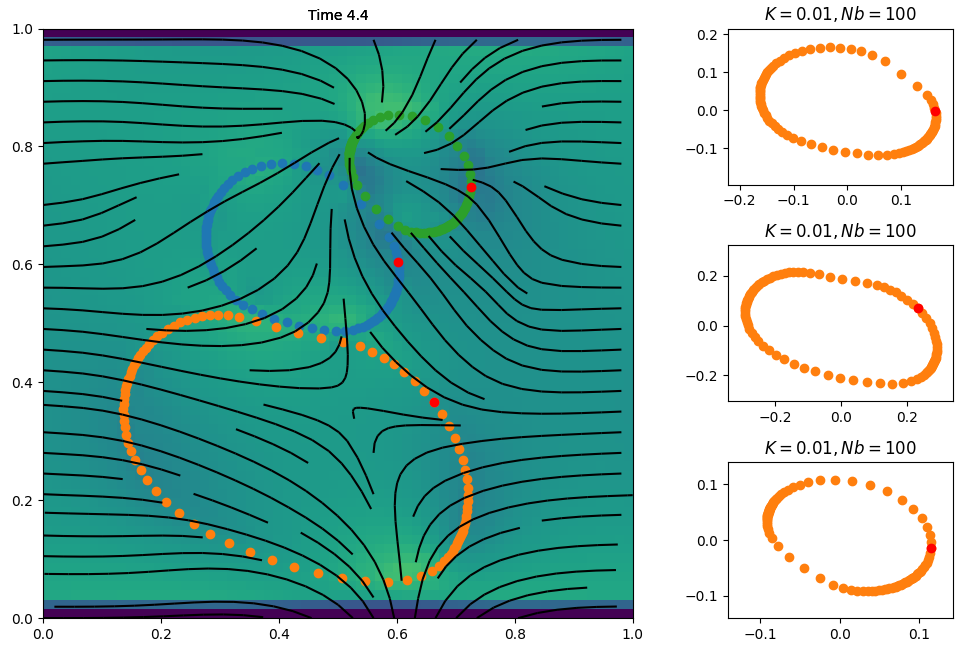

50

In [9]:
%matplotlib notebook 

#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(X)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, Nb={}$'.format(K, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

dh = display('', display_id=True)
for i, u in enumerate(U):
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    dh.update(i)
    for j, axj in enumerate(axes_frame):
        x = X[j][i]
        im.append(ax.scatter(x[:,0]%L, x[:,1]%L, color=cmap(j)))
        im.append(ax.scatter(x[0,0]%L, x[0,1]%L, color='Red'))
        im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))

        #### Plot in COM Frame
        x0 = x - np.mean(x, axis=0)
        im.append(axj.scatter(x0[:,0], x0[:,1], color=cmap(1)))
        im.append(axj.scatter([x0[0,0]], [x0[0,1]], color='red'))  ## Mark theta=0
    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [10]:
ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

In [11]:
ani2.save('ST_couette_Kpt01_noref.gif')

MovieWriter ffmpeg unavailable. Trying to use pillow instead.


# Rigid Body

In [31]:
from rpib2 import RPIB2       #### 2D penalty IB object (droplet interior)

Kp = 5000
theta = np.pi/10
rad = 0.05
Ni = 100


####################################
  ########   Simulation   ########
####################################

#### Initialize Fluid+Droplets
fluid = FLUID(N=N, L=L, mu=mu)
fluid.dt = dt
# fluid.u[1] = 5.0
# # fluid.u[1] *= np.sin(np.linspace(0, 2*np.pi, N))[np.newaxis, :]
# fluid.u[1] *= np.linspace(0, 1, N)[np.newaxis, :]
insides = [RPIB2(SUNFLOWER(rad-fluid.h/2, positions[i], n=Ni), fluid.N, fluid.h, fluid.dt) for i in range(len(positions))]
solids = insides

#### Declare Forces
for inside in insides:
    inside.Kp = Kp    
    inside.M = M 
#     inside.bForce = lambda solid, Y: GRAV(solid, Y) - 1*solid.V + 100*TRAPPING_PLANE(Y, fluid.L)

    inside.bForce = lambda solid, Y:  GRAV(solid, Y, theta=theta) + Tamp*TRAPPING_PLANE(Y, fluid.L)*(1+np.sin(2*np.pi*fluid.t/(solid.dt*Tper)))
#     inside.bForce = lambda solid, Y:  0*GRAV(solid, Y, theta=theta)
    
#### Values that we're tracking
delta = [[] for inside in insides]    ## Keep track of |X-Y|/h
V = [[] for inside in insides]
LL = [[] for inside in insides]

U = []
Xin = [[] for inside in insides]
Y = [[] for inside in insides]
for i in range(nsteps+1):
    iterate(fluid, solids)
    #### Keeping track of 'interior' properties
    for j, iin in enumerate(insides):
        delta[j].append(np.max(np.linalg.norm(iin.Y - iin.X, axis=1)))
        V[j].append(np.mean(iin.V, axis=0))
        LL[j].append(iin.L)
    if i%nmod==0:
        print(i)
        U.append(fluid.u.copy())
        for j, iin in enumerate(insides):
            Xin[j].append(iin.X.copy())
            Y[j].append(iin.Y.copy())
            

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [32]:
#### Animation
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

<IPython.core.display.Javascript object>

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500


In [33]:
ani3 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)

<IPython.core.display.Javascript object>


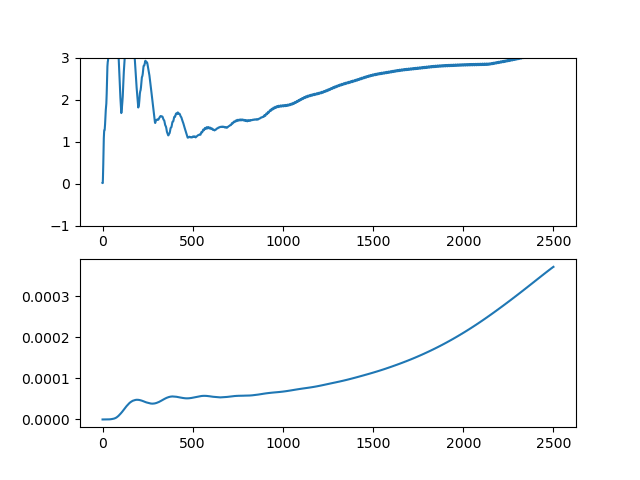

In [34]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(2, 1, 1)
ax1.set_ylim([-1, 3])
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(2, 1, 2)       
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)


Rigid Body Sedimentation Plotting Functions


In [ ]:
#### Animation
%matplotlib notebook 

fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
#     im = [show_vorticity(u, L, ax)]
    im = [ax.imshow(u[1].transpose(), origin='lower', extent=[0, L, 0, L])]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
#         im.append(axj.scatter([ins[-1,0]], [ins[-1,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
        im.append(axj.scatter([yins[-1,0]], [yins[-1,1]], color='red'))  ## Mark theta=0
        
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
#         im.append(ax.set_title('t={}'.format(1*fluid.t)))

        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

In [ ]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(3, 2, 1)
ax1.set_ylim([-1, 3])
ax1.set_title('Mass Marker Convergence')
ax1.set_ylabel('||X-Y||/h')
ax1.set_xlabel('Timestep')
for d in delta: ax1.plot(np.array(d)/fluid.h)
    
ax2 = fig2.add_subplot(3, 2, 2)       
ax2.set_title('Angular Velocity')
ax2.set_ylabel('$\omega$')
ax2.set_xlabel('Timestep')
for i in range(len(insides)): ax2.plot(0.5*dt*np.array(LL[i])/insides[i].I0)
    
ax3 = fig2.add_subplot(3, 2, 3)       
ax3.set_title('$Vx_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 4)       
ax3.set_title('$Vy_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(VCM)[i][:, 1])
    
ax3 = fig2.add_subplot(3, 2, 5)       
ax3.set_title('$X_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 0])

ax3 = fig2.add_subplot(3, 2, 6)       
ax3.set_title('$Y_{cm}$')
ax3.set_xlabel('Timestep')
for i in range(len(insides)): ax3.plot(np.array(YCM)[i][:, 1])
    
fig2.tight_layout()

In [ ]:
#### Animation
%matplotlib notebook
fig = plt.figure(constrained_layout=True)
nfigs = len(Xin)
gs = fig.add_gridspec(nfigs, nfigs+1)
ax = fig.add_subplot(gs[:, :-1])
ax.set_xlim([0, L])
ax.set_ylim([0, L])

axes_frame = [fig.add_subplot(gs[i, -1]) for i in range(nfigs)]
for j, axj in enumerate(axes_frame):
#     axj.set_title('$K={}, M={}, N_i={}$'.format(outsides[j].K, insides[j].M, len(insides[j].X)))
    axj.set_title('$K={}, M={}, N_i={}$'.format(K, M, Nb))
    
#     axj.set_xlim([-1, 1])
#     axj.set_ylim([-1, 1])
cmap = plt.get_cmap('tab10')
RED = plt.get_cmap('Reds')
ims = []

for i, u in enumerate(U):
    print(i*nmod)
    im = [show_vorticity(u, L, ax)]
    out = show_streamlines(u, L, ax)
    im.append(out.lines)
    for k, X in enumerate([Xin, Xout]):
        for j, x in enumerate(X): 
            im.append(ax.scatter(x[i][:,0]%L, x[i][:,1]%L, color=cmap(2*j+k)))
            im.append(ax.text(0.5, 1.01, 'Time {}'.format(i*nmod*dt), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes))
    for j, axj in enumerate(axes_frame):
        #### Plot Droplets in COM Frame
        xin = Xin[j][i]
        xout = Xout[j][i]
        com = np.mean(xin, axis=0)
        ins = xin - com
        out = xout - com

        im.append(axj.scatter(ins[:,0], ins[:,1], s=1000/Ni, color=cmap(0)))
        im.append(axj.scatter(out[:,0], out[:,1], color=cmap(1)))
        im.append(axj.scatter([out[0,0]], [out[0,1]], color='red'))  ## Mark theta=0
        
        ### DEBUG ####
        yins = Y[j][i] - com
        im.append(axj.scatter(yins[:,0], yins[:,1], s=1000/Ni, color=cmap(1)))
#         TETHERS = np.array([[ins[i], yins[i]] for i in range(len(ins))])
#         for tether in TETHERS:
#             im.extend(axj.plot(tether[:,0], tether[:,1], color=RED(np.linalg.norm(tether[1]-tether[0])*N/L)))
        
        ## Record theta profile of each boundary
#             THETA[j].append(np.arctan2(out[:,1], out[:,0]))


    ims.append(im) 
        
#### Credit: Stack Exchange  https://stackoverflow.com/questions/61932534/cannot-remove-streamplot-arrow-heads-from-matplotlib-axes
from matplotlib import patches
for art in ax.get_children():
    if not isinstance(art, patches.FancyArrowPatch):
        continue
    art.remove()        # Method 1
    # art.set_alpha(0)  # Method 2  


    
    
# ani2 = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1)
# ani2.save('single_droplet.gif', writer='pillow')

$E = K\sum_{i=0}^{N-1} \frac{1}{2} K||X_i-X_{i-1}||^2$

$F_i = -\frac{\partial E}{\partial X_i} = -K(X_i - X_{i-1}) + K(X_{i+1} - X_i)$
